<a href="https://colab.research.google.com/github/samwu15/CY-Profile.md/blob/main/EEE6778_final_clip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/samwu15/EEE6778_final_clip.git

Cloning into 'EEE6778_final_clip'...
remote: Enumerating objects: 2200, done.
remote: Total 2200 (delta 0), reused 0 (delta 0), pack-reused 2200 (from 1)
Receiving objects: 100% (2200/2200), 175.51 MiB | 13.79 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [4]:
import os

# 你的專案資料夾名稱（已經照你給的改好了）
PROJECT_DIR = "/content/EEE6778_final_clip"

# 如果你的圖片是在 data/shanshui 底下，就用這行：
DATA_DIR = os.path.join(PROJECT_DIR, "data", "shanshui")

# 如果你圖片是直接放在 data/ 底下，就改成：
# DATA_DIR = os.path.join(PROJECT_DIR, "data")

OUTPUT_DIR = os.path.join(PROJECT_DIR, "outputs")
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("PROJECT_DIR:", PROJECT_DIR)
print("DATA_DIR   :", DATA_DIR)
print("OUTPUT_DIR :", OUTPUT_DIR)

print("\ndata 資料夾前 10 個檔案：")
print(os.listdir(DATA_DIR)[:10])


PROJECT_DIR: /content/EEE6778_final_clip
DATA_DIR   : /content/EEE6778_final_clip/data/shanshui
OUTPUT_DIR : /content/EEE6778_final_clip/outputs

data 資料夾前 10 個檔案：
['met_44.jpg', 'met_84.jpg', 'puam_341.jpg', 'met_194.jpg', 'smithsonian_529.jpg', 'smithsonian_62.jpg', 'met_175.jpg', 'met_305.jpg', 'smithsonian_306.jpg', 'puam_75.jpg']


In [5]:
!pip install ftfy regex tqdm scikit-learn matplotlib gradio
!pip install git+https://github.com/openai/CLIP.git

import torch
print("PyTorch 版本:", torch.__version__)
print("CUDA 是否可用:", torch.cuda.is_available())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.6 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-fperhp2p
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-fperhp2p
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=6f35e19794dd897a6e64dc1511eed79eea2488964efd900db67ead6a39b9690a
  Stored in directory: /tmp/pip-ephem-wheel-cache-fv8ma3eg/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip
PyTorch 版本: 2.9.0+cu126
CUDA 是否可用: False


In [6]:
import numpy as np
from PIL import Image
from tqdm import tqdm

import clip
import torch
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print("使用裝置:", device)

model, preprocess = clip.load("ViT-B/32", device=device)

embeddings = []
filenames = []

file_list = sorted(os.listdir(DATA_DIR))
print("共找到檔案數量:", len(file_list))

for fname in tqdm(file_list):
    fpath = os.path.join(DATA_DIR, fname)

    if not os.path.isfile(fpath):
        continue
    if not fname.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".webp")):
        continue

    try:
        img = Image.open(fpath).convert("RGB")
    except Exception as e:
        print("讀圖失敗，略過：", fname, e)
        continue

    img_tensor = preprocess(img).unsqueeze(0).to(device)

    with torch.no_grad():
        feats = model.encode_image(img_tensor)
        feats = feats / feats.norm(dim=-1, keepdim=True)  # L2 normalize
        emb = feats.cpu().numpy().flatten()

    embeddings.append(emb)
    filenames.append(fname)

embeddings = np.array(embeddings)
filenames = np.array(filenames)

np.save(os.path.join(OUTPUT_DIR, "clip_embeddings.npy"), embeddings)
np.save(os.path.join(OUTPUT_DIR, "filenames.npy"), filenames)

print("Done.")
print("embeddings shape:", embeddings.shape)
print("num images:", len(filenames))


使用裝置: cpu


100%|███████████████████████████████████████| 338M/338M [00:03<00:00, 91.1MiB/s]


共找到檔案數量: 2192


100%|██████████| 2192/2192 [08:30<00:00,  4.30it/s]

Done.
embeddings shape: (2192, 512)
num images: 2192


Embedding shape: (2192, 512)


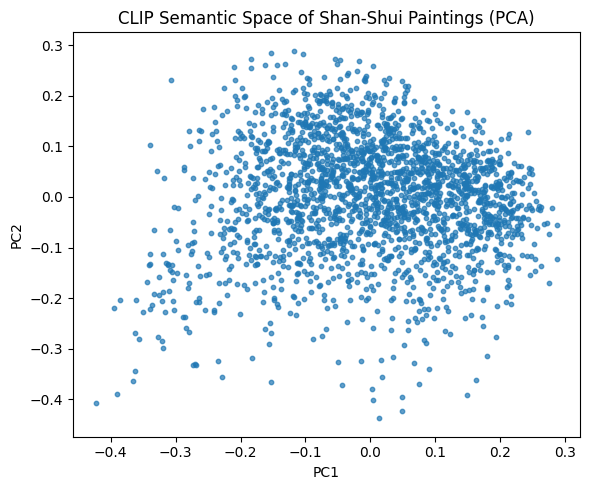

In [7]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import os

emb = np.load(os.path.join(OUTPUT_DIR, "clip_embeddings.npy"))
filenames = np.load(os.path.join(OUTPUT_DIR, "filenames.npy"))

print("Embedding shape:", emb.shape)

pca = PCA(n_components=2)
xy = pca.fit_transform(emb)

plt.figure(figsize=(6, 5))
plt.scatter(xy[:, 0], xy[:, 1], alpha=0.7, s=10)
plt.title("CLIP Semantic Space of Shan-Shui Paintings (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

# 存一份到專案 outputs 給報告用
plt.figure(figsize=(6, 5))
plt.scatter(xy[:, 0], xy[:, 1], alpha=0.7, s=10)
plt.title("CLIP Semantic Space of Shan-Shui Paintings (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "pca_scatter.png"), dpi=300)
plt.close()


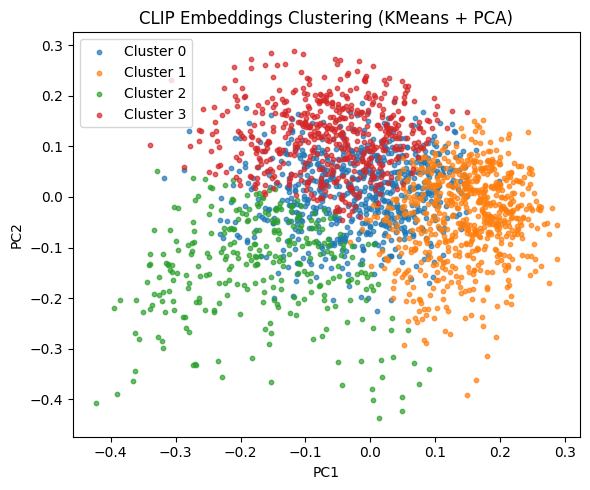

In [8]:
from sklearn.cluster import KMeans

k = 4  # 可以自己改 3~6 看看
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(emb)

np.save(os.path.join(OUTPUT_DIR, "cluster_labels.npy"), labels)

plt.figure(figsize=(6, 5))
for i in range(k):
    mask = (labels == i)
    plt.scatter(xy[mask, 0], xy[mask, 1], alpha=0.7, s=10, label=f"Cluster {i}")

plt.title("CLIP Embeddings Clustering (KMeans + PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()

# 存成圖檔給報告用
plt.figure(figsize=(6, 5))
for i in range(k):
    mask = (labels == i)
    plt.scatter(xy[mask, 0], xy[mask, 1], alpha=0.7, s=10, label=f"Cluster {i}")
plt.title("CLIP Embeddings Clustering (KMeans + PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "pca_clusters.png"), dpi=300)
plt.close()


In [10]:
import gradio as gr
from PIL import Image
import numpy as np
import os
import torch
import clip

emb_dataset = np.load(os.path.join(OUTPUT_DIR, "clip_embeddings.npy"))
filenames = np.load(os.path.join(OUTPUT_DIR, "filenames.npy"))

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

def find_similar(uploaded_img, top_k=5):
    if uploaded_img is None:
        return []

    img = uploaded_img.convert("RGB")
    img_tensor = preprocess(img).unsqueeze(0).to(device)

    with torch.no_grad():
        img_feat = model.encode_image(img_tensor)
        img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)
        query_emb = img_feat.cpu().numpy().flatten()

    sims = emb_dataset @ query_emb
    idx_sorted = sims.argsort()[::-1]
    top_idx = idx_sorted[:top_k]

    results = []
    for i in top_idx:
        fname = filenames[i]
        path = os.path.join(DATA_DIR, fname)
        score = float(sims[i])
        try:
            img_i = Image.open(path).convert("RGB")
        except:
            continue
        results.append((img_i, f"{fname} | sim={score:.3f}"))

    return results

demo = gr.Interface(
    fn=find_similar,
    inputs=gr.Image(type="pil", label="上傳一張山水畫或相似圖片"),
    outputs=gr.Gallery(label="最相似的山水畫 Top-K"),
    title="CLIP 山水畫相似度搜尋 Demo",
    description="上傳圖片，系統會用 CLIP 在資料集中找出最相似的山水畫。"
)

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://aa2126f0ba31d17b4c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
